In [183]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
import numpy as np
import time
import warnings

In [184]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

In [185]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import shap

# Load Data

In [186]:
df = pd.read_csv("../../data/AmesHousing.csv")
df.head()
df = df.select_dtypes(include="number")
df.dropna(inplace=True)
df["random_feature"] = np.random.random(df.shape[0])
df["random_feature2"] = np.random.random(df.shape[0])
df["random_feature3"] = np.random.random(df.shape[0])
df["random_feature4"] = np.random.random(df.shape[0])
df["Overall Qual Noise"] = df["Overall Qual"] + (df["random_feature"] * 0.0001)
df["Overall Cond Noise"] = df["Overall Cond"] + (df["random_feature"] * 0.0001)
# Split the data
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(
    df.drop("SalePrice", axis=1), df["SalePrice"], test_size=test_size, random_state=42
)

# Select Features

In [187]:
from sklearn.base import BaseEstimator


class SubsetEvaluator:
    def evaluate(self, subset):
        raise NotImplementedError


from sklearn.model_selection import cross_val_score

In [188]:
from sklearn.base import BaseEstimator
import numpy as np
import itertools

from sklearn.base import BaseEstimator


class SubsetSelector(BaseEstimator):
    def __init__(self):
        self.subsets_history = []
        self.performance_history = []

    def update_history(self, subset, performance):
        self.subsets_history.append(subset)
        self.performance_history.append(performance)

    def generate_next_subset(self):
        raise NotImplementedError


import random


class RandomSubsetSelector(SubsetSelector):
    def __init__(self, features, random_state=None):
        super().__init__()
        self.features = list(features)
        self.random_state = random_state  # Use a local Random instance
        np.random.seed(self.random_state)

    def generate_next_subset(self):
        max_attempts = 100
        for _ in range(max_attempts):
            num_features = np.random.randint(1, len(self.features))
            subset = np.random.choice(self.features, num_features, replace=False)
            subset = sorted(subset)  # Sort the subset
            subset_tuple = tuple(subset)  # Convert to tuple
            if subset_tuple not in self.subsets_history:
                return subset
        raise ValueError(
            "Unable to find a new unique subset after {} attempts".format(max_attempts)
        )


class SubsetFeatureSelector:
    def __init__(self, subset_selector, evaluator, n_steps, greater_is_better=True):
        self.subset_selector = subset_selector
        self.evaluator = evaluator
        self.n_steps = n_steps
        self.greater_is_better = greater_is_better
        self.subset_history = []
        self.score_history = []

    def _is_better(self, current_performance, best_performance):
        if self.greater_is_better:
            return current_performance > best_performance
        else:
            return current_performance < best_performance

    def find_optimal_subset(self):
        if self.greater_is_better:
            best_performance = float("-inf")
        else:
            best_performance = float("inf")

        best_subset = None

        for _ in range(self.n_steps):
            subset = self.subset_selector.generate_next_subset()
            performance = self.evaluator.evaluate(subset)
            self.subset_selector.update_history(subset, performance)

            if self._is_better(performance, best_performance):
                best_subset, best_performance = subset, performance
                print(f"Best score so far: {performance}")
                self.subset_history.append(best_subset)
                self.score_history.append(best_performance)

        self.best_subset = best_subset
        self.best_score = best_performance  # todo: change to 'score'
        return best_subset, best_performance

In [189]:
from sko.PSO import PSO
import numpy as np

class PSOSubsetSelector(SubsetSelector):
    def __init__(self, features, evaluator, pop_size=30, max_iter=100, w=0.8, c1=0.5, c2=0.5):
        super().__init__()
        self.features = features
        self.evaluator = evaluator
        self.pop_size = pop_size
        self.max_iter = max_iter
        self.subsets_history_set = set()  # Initialize the set to store history of subsets
        self.w = w
        self.c1 = c1
        self.c2 = c2
        self.run_pso()  # Initialize and run PSO

    def run_pso(self):
        # Function to run PSO, allows for re-running PSO in case of repeat solutions
        self.pso = PSO(
            func=self._pso_func,
            n_dim=len(self.features),
            pop=self.pop_size,
            max_iter=self.max_iter,
            lb=[0] * len(self.features),
            ub=[1] * len(self.features),
            w=self.w, c1=self.c1, c2=self.c2
        )
        self.pso.run()

    def subset_fitness(self, position):
        # Convert continuous position values to binary to decide feature inclusion
        subset = tuple(self.features[i] for i in range(len(self.features)) if position[i] > 0.5)
        if not subset or subset in self.subsets_history_set:
            return float("inf")  # Penalize empty subsets or repeats if maximizing
        # Calculate fitness for new, unique subsets
        fitness = self.evaluator.evaluate(list(subset))
        self.update_history(list(subset), fitness)
        return fitness

    def _pso_func(self, x):
        # Wrapper to adjust the fitness function interface
        return self.subset_fitness(x)

    def generate_next_subset(self):
        # Ensure that the best subset hasn't been picked before
        for _ in range(10):  # Limit the number of retries to prevent infinite loops
            best_position = self.pso.gbest_x
            subset = [self.features[i] for i in range(len(self.features)) if best_position[i] > 0.5]
            subset_tuple = tuple(subset)
            if subset_tuple not in self.subsets_history_set:
                self.subsets_history_set.add(subset_tuple)
                return subset
            else:
                # Rerun PSO or modify parameters to explore new areas
                self.run_pso()
        raise ValueError("Unable to find a new unique subset after multiple attempts")

    def update_history(self, subset, performance):
        super().update_history(subset, performance)
        self.subsets_history_set.add(tuple(subset))  # Store subsets as tuples in a set for fast lookup

In [190]:
from sklearn.model_selection import GroupShuffleSplit, GroupKFold

In [191]:
from sklearn.model_selection import ShuffleSplit


class HoldOutSubsetEvaluator(SubsetEvaluator):
    def __init__(
        self,
        X,
        y,
        estimator,
        scorer,
        splitter=None,
        groups=None,
        test_size=0.2,
        random_state=43,
    ):
        self.X = X
        self.y = y
        self.estimator = estimator
        self.scorer = scorer
        self.test_size = test_size
        self.groups = groups
        self.random_state = random_state
        self.splitter = ShuffleSplit if splitter is None else splitter
        self._split_data()

    def _split_data(self):
        # Splitting the dataset into training and test sets
        self.splitter = self.splitter(
            n_splits=1, test_size=self.test_size, random_state=self.random_state
        )
        for train_index, test_index in self.splitter.split(self.X, groups=self.groups):
            self.X_train, self.X_test = (
                self.X.iloc[train_index],
                self.X.iloc[test_index],
            )
            self.y_train, self.y_test = (
                self.y.iloc[train_index],
                self.y.iloc[test_index],
            )

    def evaluate(self, subset):
        if hasattr(self.estimator, "pre_fit"):
            self.estimator.pre_fit(self.X_train, self.y_train, self.X_test, self.y_test)

        # Fit the estimator using only the selected features from the training set
        self.estimator.fit(self.X_train[subset], self.y_train)

        # Generate predictions for the test set using the same subset of features
        y_pred = self.estimator.predict(self.X_test[subset])

        # Evaluate the predictions
        return self.scorer(self.y_test, y_pred)

In [192]:
random_state = 43
scorer = mean_absolute_percentage_error

In [193]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(n_estimators=100, n_jobs=-1, verbose=-100)

In [194]:
from sklearn.pipeline import Pipeline
# from category_encoders import MEstimateEncoder

In [195]:
# enc = MEstimateEncoder(cols=cat_cols)

In [196]:
import shap
from sklearn.base import BaseEstimator

import shap
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestRegressor


class SHAPEstimator(BaseEstimator):  # TODO: change to ShapEstimator
    def __init__(self, estimator, explainer=None):
        self.estimator = estimator
        self.shap_values = None
        self.explainer = explainer
        self.initial_fit = False

    def pre_fit(self, X_train, y_train, X_test, y_test=None):
        if self.initial_fit is False:
            self.estimator.fit(X_train, y_train)
            self.explainer = (
                shap.Explainer(self.estimator)
                if self.explainer is None
                else self.explainer(self.estimator)
            )
            self.feature_names = X_test.columns
            self.shap_values = self.explainer.shap_values(X_test)
            self.shap_expected_value = self.explainer.expected_value
            self.initial_fit = True

    def fit(self, X, y):
        pass

    def predict(self, X):
        # Find indices of X's columns in the original feature names
        column_indices = [self.feature_names.get_loc(col) for col in X.columns]
        # Subset the stored SHAP values using the indices
        selected_shap_values = self.shap_values[:, column_indices]
        # Sum the SHAP values across rows to get the prediction approximation
        return self.shap_expected_value + selected_shap_values.sum(axis=1)


from sklearn.base import BaseEstimator
import numpy as np

In [197]:
class SKLearnEstimator(BaseEstimator):
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y):
        return self.estimator.fit(X_train, y_train)

    def predict(self, X):
        return self.estimator.predict(X)

In [198]:
from sklearn.model_selection import cross_val_score


class CVSubsetEvaluator(SubsetEvaluator):
    def __init__(self, X, y, estimator, scorer, cv, groups=None, random_state=None):
        self.X = X
        self.y = y
        self.estimator = estimator
        self.scorer = scorer
        self.cv = cv
        self.groups = groups
        self.random_state = random_state

    def evaluate(self, subset):
        if hasattr(self.estimator, "pre_fit"):
            self.estimator.pre_fit(self.X, self.y)

        # Evaluate using cross-validation.
        # The cross_val_score function takes care of splitting the data.
        scores = cross_val_score(
            self.estimator,
            self.X[subset],
            self.y,
            scoring=self.scorer,
            cv=self.cv,
            groups=self.groups,
            n_jobs=-1,
        )

        # You can return the mean score across all folds, or modify this to return a different summary statistic.
        return scores.mean()

In [199]:
estimator = SHAPEstimator(lgb_model, shap.TreeExplainer)

In [200]:
from sklearn.metrics import make_scorer, mean_absolute_percentage_error

In [201]:
#mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [202]:
cv = GroupKFold(n_splits=5)

In [203]:
evaluator = CVSubsetEvaluator(X_train, y_train, lgb_model, scorer, cv=5)

In [204]:
evaluator = CVSubsetEvaluator(X_train, y_train, estimator, scorer, cv=5)

In [205]:
evaluator = HoldOutSubsetEvaluator(
    X_train, y_train, estimator, scorer, test_size=0.2, random_state=random_state
)

In [206]:
subset_selector = RandomSubsetSelector(X_train.columns, random_state=random_state)
sfs = SubsetFeatureSelector(subset_selector, evaluator, n_steps=10000, greater_is_better=False)

In [207]:
%%time
sfs.find_optimal_subset()

Best score so far: 0.3484956514614597
Best score so far: 0.11996897998917146
Best score so far: 0.09924650201059733
Best score so far: 0.09492870907162729
Best score so far: 0.09457382522973737
Best score so far: 0.093870993329254
Best score so far: 0.0937951964756408
CPU times: user 6.14 s, sys: 1.51 s, total: 7.65 s
Wall time: 7.12 s


(['1st Flr SF',
  '2nd Flr SF',
  '3Ssn Porch',
  'Bedroom AbvGr',
  'Bsmt Full Bath',
  'Bsmt Half Bath',
  'BsmtFin SF 1',
  'BsmtFin SF 2',
  'Enclosed Porch',
  'Fireplaces',
  'Full Bath',
  'Garage Area',
  'Garage Cars',
  'Garage Yr Blt',
  'Gr Liv Area',
  'Half Bath',
  'Kitchen AbvGr',
  'Lot Area',
  'Lot Frontage',
  'Low Qual Fin SF',
  'MS SubClass',
  'Mas Vnr Area',
  'Misc Val',
  'Mo Sold',
  'Order',
  'Overall Cond',
  'Overall Cond Noise',
  'Overall Qual',
  'Overall Qual Noise',
  'PID',
  'Pool Area',
  'Screen Porch',
  'TotRms AbvGrd',
  'Total Bsmt SF',
  'Wood Deck SF',
  'Year Built',
  'Year Remod/Add',
  'Yr Sold',
  'random_feature',
  'random_feature3',
  'random_feature4'],
 0.0937951964756408)

In [208]:
subset = sfs.best_subset

In [223]:
lgb_model.fit(X_train[subset], y_train)
y_pred = lgb_model.predict(X_test[subset])
scorer(y_test, y_pred)

0.09988693927743557

In [210]:
import plotly.express as px

In [211]:
selector = sfs.subset_selector

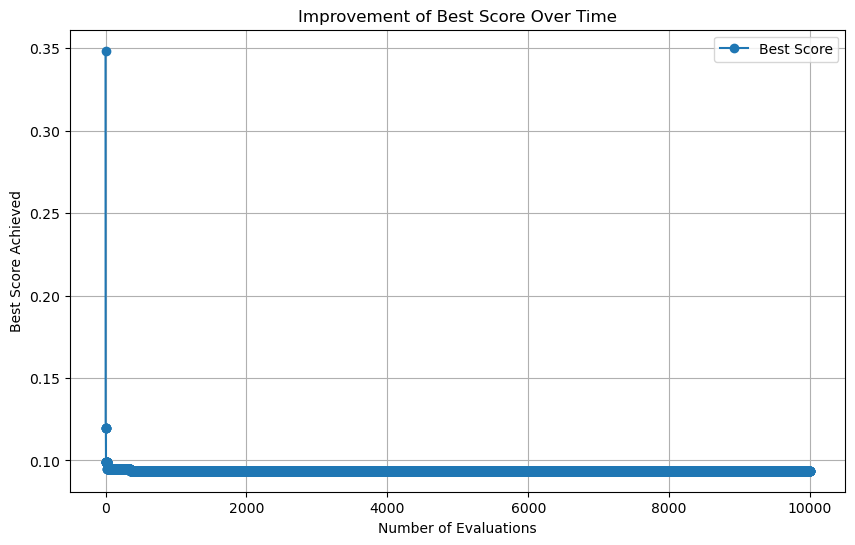

In [212]:
import matplotlib.pyplot as plt

# Assuming 'selector.performance_history' is a list of scores for each subset evaluated
performance_history = selector.performance_history

# Compute the best score up to each point in the history
best_scores = [min(performance_history[:i+1]) for i in range(len(performance_history))]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(best_scores, label='Best Score', marker='o')
plt.xlabel('Number of Evaluations')
plt.ylabel('Best Score Achieved')
plt.title('Improvement of Best Score Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [213]:
compare_subsample = 100
performance_history = selector.performance_history[:compare_subsample]
subsets_history = selector.subsets_history[:compare_subsample]
subset_sizes = [len(subset) for subset in subsets_history]

In [214]:
%%time
true_scores = []
for subset in subsets_history:
    lgb_model.fit(X_train[subset], y_train)
    y_pred = lgb_model.predict(X_test[subset])
    true_scores.append(scorer(y_test, y_pred))

CPU times: user 24.3 s, sys: 55.1 s, total: 1min 19s
Wall time: 47.2 s


In [215]:
df = pd.DataFrame({"Predicted Score" : performance_history, "True Score" : true_scores, "Subset Size" : subset_sizes})

In [216]:
df = pd.DataFrame({"Predicted Score" : performance_history, "True Score" : true_scores, "Subset Size" : subset_sizes})
df["Predicted Rank"] = df["Predicted Score"].rank(ascending=True, method='min')
df["True Rank"] = df["True Score"].rank(ascending=True, method='min')

In [217]:
px.scatter(df, x="Predicted Rank", y="True Rank", size="Subset Size")

In [218]:
px.scatter(df, x="Predicted Score", y="True Score", size="Subset Size")

In [219]:
import scipy

In [220]:
# correlation: true_scores vs selector.performance_history
cor = scipy.stats.spearmanr(true_scores, performance_history)
cor

SignificanceResult(statistic=0.9313411341134112, pvalue=8.723164539993612e-45)

In [221]:
# correlation: true_scores vs selector.performance_history
cor = scipy.stats.pearsonr(true_scores, performance_history)
cor

PearsonRResult(statistic=0.7655648402120474, pvalue=1.7645572148210853e-20)